# Part 0: Initialising

In [1]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap('nipy_spectral')

mpl.rcParams.update(params)

import warnings

warnings.filterwarnings("ignore")

To start with, we import three datasets that are available from YouNiverse:

``df_timeseries_en.tsv.gz``  
``df_channels_en.tsv.gz``  
``yt_metadata_helper.feather``

We will filter the channels that have been identified as Gaming, People & Blogs, or Comedy.

In [2]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

# filter channels we want
df_time_series = df_time_series[df_time_series.category.isin(
    ['Gaming', 'People & Blogs', 'Comedy']
)]

In [3]:
df_time_series.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
301,UCxJWPpPED-J24znoKyKZYjg,Comedy,2017-03-06,1607.50,285.50,183.0,0.0,7,0,2
302,UCxJWPpPED-J24znoKyKZYjg,Comedy,2017-03-13,2695.75,1088.25,317.0,134.5,8,1,2


In [4]:
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

# filter channels we want
df_channels = df_channels[df_channels.category_cc.isin(
    ['Gaming', 'People & Blogs', 'Comedy']
)]

In [40]:
channel_id_gaming = df_channels[df_channels['category_cc']=='Gaming'].channel
channel_id_people_blogs = df_channels[df_channels['category_cc']=='People & Blogs'].channel
channel_id_comedy = df_channels[df_channels['category_cc']=='Comedy'].channel


In [5]:
df_channels.head(4)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
10,Gaming,2015-04-06,UCEdvpU2pFRCVqU6yIPyTpMQ,Marshmello,39100000,366,18.0,2.087
40,Comedy,2005-11-19,UCY30JRSgfhYXA6i6xX1erWg,Smosh,24800000,1074,85.0,2.087
41,Gaming,2012-05-26,UC7_YxT-KID8kRbqZo7MyscQ,Markiplier,24400000,4484,86.0,2.087


In [6]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
        "display_id"
    ],
)

video_metadatas = video_metadatas[
    video_metadatas['channel_id'].isin(df_channels.channel)
]

In [ ]:
video_metadatas_gaming = video_metadatas[
    video_metadatas['channel_id'].isin(channel_id_gaming)
]

video_metadatas_people_blogs = video_metadatas[
    video_metadatas['channel_id'].isin(channel_id_people_blogs)
]

video_metadatas_comedy = video_metadatas[
    video_metadatas['channel_id'].isin(channel_id_comedy)
]

In [41]:
display_id_gaming = video_metadatas_gaming.display_id
display_id_people_blogs = video_metadatas_people_blogs.display_id
display_id_comedy = video_metadatas_comedy.display_id

In [8]:
video_metadatas.head()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA,SBqSc91Hn9g
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA,UuugEl86ESY
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA,oB4c-yvnbjs
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA,ZaV-gTCMV8E
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA,cGvL7AvMfM0


We also import a dataset that is created by us, .......  

We will filter the channels that have been identified as Gaming, People & Blogs, or Comedy. Note that this does not necessarily mean that all the videos from those channels are in these categories.

In [9]:
titles_metadata = pd.read_feather(
    "./data/yt_metadata_title_helper.feather")

titles_metadata = titles_metadata[
    titles_metadata['display_id'].isin(video_metadatas.display_id)
]

In [43]:
titles_metadata_gaming = titles_metadata[
    titles_metadata['display_id'].isin(display_id_gaming)
]

titles_metadata_people_blogs = titles_metadata[
    titles_metadata['display_id'].isin(display_id_people_blogs)
]

titles_metadata_comedy = titles_metadata[
    titles_metadata['display_id'].isin(display_id_comedy)
]

In [11]:
titles_metadata.head()

,categories,display_id,title
0,Film & Animation,SBqSc91Hn9g,Lego City Police Lego Firetruck Cartoons about...
1,Film & Animation,UuugEl86ESY,Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...
2,Film & Animation,oB4c-yvnbjs,Lego City Police Lego Fireman Cartoons about L...
3,Film & Animation,ZaV-gTCMV8E,Lego Harry Potter Complete Lego New Movie for ...
4,Film & Animation,cGvL7AvMfM0,Lego City Police 1 HOUR LONG VIDEO for kids Le...


In [12]:
tags_metadata = pd.read_feather(
    "./data/yt_metadata_tags_helper.feather")

tags_metadata = tags_metadata[
    tags_metadata['display_id'].isin(tags_metadata.display_id)
]

In [44]:
tags_metadata_gaming = tags_metadata[
    tags_metadata['display_id'].isin(display_id_gaming)
]

tags_metadata_people_blogs = tags_metadata[
    tags_metadata['display_id'].isin(display_id_people_blogs)
]

tags_metadata_comedy = tags_metadata[
    tags_metadata['display_id'].isin(display_id_comedy)
]

In [52]:
# note the tags also include other languages...
tags_metadata_comedy.tags[10093]

'csgo,gaming,funny,spl1tex,splitex,face,JOSKIY,bunnyhopper,bunnyhop,wallhack,wtf,moments,counterstrikeglobaloffensive,spl1tex cs go,josky spl1tex,spl1tex мой калашников,spl1tex cfg,spl1tex standoff 2,spl1tex купил драгон лор,spl1tex стал русски,spl1tex апнул глобала,spl1tex купил вой,splitex мой калашников,splitex лицо,splitex стал русским,splitex face,splitex купил драгон лор,splitex song,spl1tex joskiy,Spl1tex КС:ГО,КС:ГО,Brawl Stars'

In [61]:
tags_metadata_comedy.tags.iloc[200]

'scammed,i got scammed,vlog,Entertainment,Soron,Bike vlog,eminem,rap god,fidget spinner,fidget spinners,scam,scamming,scammer'

In [14]:
tags_metadata.head()

,categories,display_id,tags
0,Film & Animation,SBqSc91Hn9g,"lego city,lego police,lego city police,lego ci..."
1,Film & Animation,UuugEl86ESY,"Lego superheroes,lego hulk,hulk smash,lego mar..."
2,Film & Animation,oB4c-yvnbjs,"lego city,lego police,lego city police,lego fi..."
3,Film & Animation,ZaV-gTCMV8E,"Lego harry potter,new harry potter,harry potte..."
4,Film & Animation,cGvL7AvMfM0,"lego city,lego police,lego city police,lego fi..."


# Part 2: Further Analysis Milestone 3

Given the results in Part 1 of our Analysis, we decided to focus on the categories of Gaming, People & Blogs, Comedy. The reason behind this choice is because we are trying to help our little brother to succeed, and since he is just a single person without a big team behind him it seems more reasonable than e.g. Movies or Film & Entertainment. Therefore, we decided to eliminate Music, How-to & Style, Education, Science & Technology, Entertainment, Film & Entertainment, Movies and Shows. We decided to investigate the three categories mentioned above also because videos uploaded can be addressed to audiences of all three categories.

## Key Questions:
 - Which factors help a YouTuber in Gaming, People & Blogs or Comedy respectively gain more subscribers?
 - How do sentiments in titles and tags affect views and how do these relationships change over time?

### Sub-Question 1 

**Description:** How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?  
**Method:** Model this using a linear regression model.  
**Timeline:** By 13/12/2022  
**Organization:** Paul  

### Sub-Question 2

**Description:** How does the language used in titles affect subscription number?  
**Method:** We will classify the sentiments of titles and tags using packages such as NLTK and try to see if this factor affects subscription number of the channels using relevant skills we learned in observational studies.  
**Timeline:** By 15/12/2022  
**Organization:** Wenxiu  

In [15]:
#NLP libraries
import spacy, nltk, gensim, sklearn

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
# Initialise the Spacy analyzer in English
nlp = spacy.load('en_core_web_sm')

In [30]:
positive_sent = []
negative_sent = []
neutral_sent = []
compound_sent = []

#iterate through the sentences, get polarity scores, choose a value
analyzer = SentimentIntensityAnalyzer()
for title in titles_metadata.title:
    score = analyzer.polarity_scores(title)
    positive_sent.append(score['pos'])
    negative_sent.append(score['neg'])
    neutral_sent.append(score['neu'])
    compound_sent.append(score['compound'])

Text(0, 0.5, 'Number of sentences')

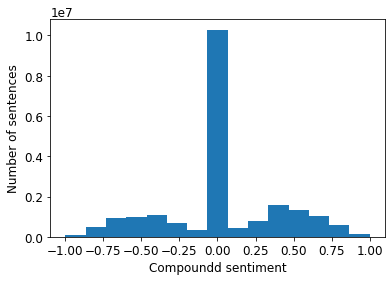

In [35]:
plt.hist(compound_sent,bins=15)
plt.xlabel('Compoundd sentiment')
plt.ylabel('Number of titles')

Text(0, 0.5, 'Number of sentences')

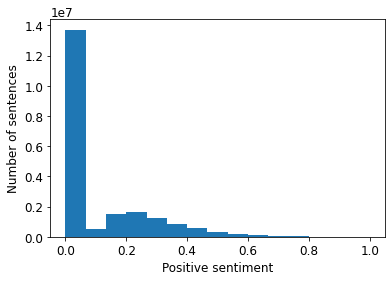

In [36]:
plt.hist(positive_sent,bins=15)
plt.xlabel('Positive sentiment')
plt.ylabel('Number of titles')

Text(0, 0.5, 'Number of sentences')

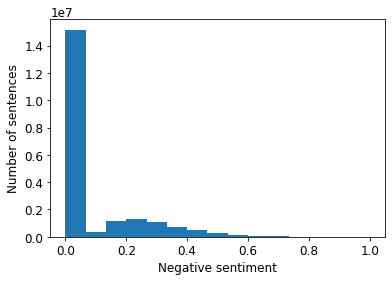

In [37]:
plt.hist(negative_sent,bins=15)
plt.xlabel('Negative sentiment')
plt.ylabel('Number of titles')

Text(0, 0.5, 'Number of sentences')

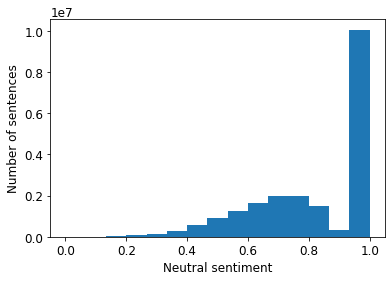

In [38]:
plt.hist(neutral_sent,bins=15)
plt.xlabel('Neutral sentiment')
plt.ylabel('Number of titles')

### Sub-Question 3

**Description:** Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, person pronouns to address the viewers, the number of words in the title, and the number of tags used?  
**Method:** We can implement kNN method or Random Forests to train the dataset.  
**Timeline:** By 13/12/2022  
**Organization:** Dorothee  

### Sub-Question 4
**Description:** What are the most common topics in each of the chosen categories?  
**Method:** The yt_metadata_en.jsonl.gz dataset will be used to get a list of tags of each video according to its category. It is further split and classified according to the topics that occur most frequently. This way, we get the most used keywords in each video category and therefore the most popular topics.  
**Timeline:** By 15/12/2022  
**Organization:** Jules  

### Sub-Question 5
**Description:** Does a channel's success increase with a greater variety of categories?
**Method:** For this question, we will determine whether the filtered channels use multiple categories in their videos, and if they showed clear shifts from one category to another. Ultimately, we want to use this information and methods such as A/B testing and observational studies to determine whether a greater variety of categories can aid to a channels’ success.  
**Timeline:** By 18/12/2022  
**Organization:** Paul  